In [ ]:
#| hide
from LensCalcPy.pbh import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
from LensCalcPy.stats import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# LensCalcPy

> Calculate Microlensing Observables

Will write a better readme soon

## Install

```sh
pip install LensCalcPy
```

## How to use

### Note that all functionality is currently for a survey of the MW bulge. Will be able to customize to other surveys soon.


We can calculate the distribution of crossing times for a given PBH population

In [ ]:
f_pbh = 1 # fraction of dark matter in PBHs

ts = np.logspace(-2, 1, 30)
pbhs = [Pbh(10**(i), f_pbh) for i in np.linspace(-9, -7, 3)]
result = np.zeros((len(pbhs), len(ts)))
for i, pbh in enumerate(pbhs):
    result[i, :] = pbh.compute_differential_rate(ts)

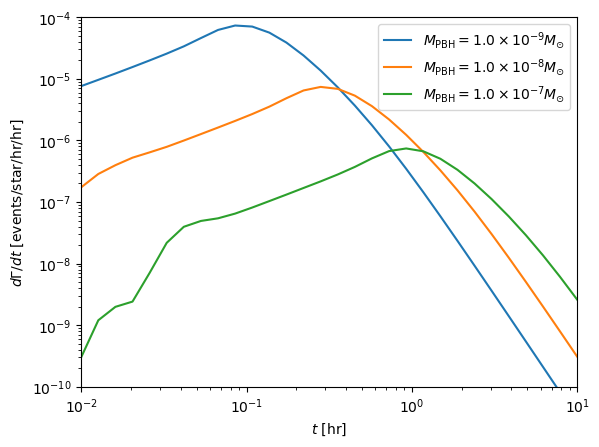

In [ ]:
for i, pbh in enumerate(pbhs):
    # plt.loglog(ts, result[i], label=r"$M_{\rm{PBH}} = " + str(pbh.m_pbh) + "M_{\odot}$")
    plt.loglog(ts, result[i], label=r"$M_{\rm{PBH}} = $" + scientific_format(pbh.mass,0) + "$M_{\odot}$")


plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.xlim(1e-2, 1e1)
plt.ylim(1e-10, 1e-4)

plt.legend()
plt.show()


Similarly, we can calculate the distribution of crossing times for an FFP population

In [ ]:
mMin = 1e-7  # solar masses
alpha = 2
fp = FfpPopulation(mMin, alpha)

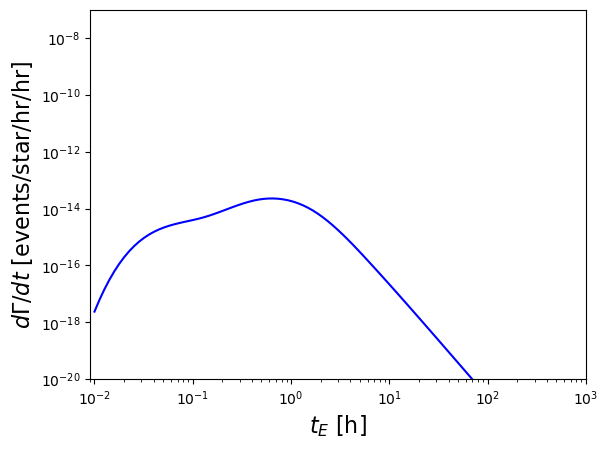

In [ ]:
ts = np.logspace(-2, np.log10(1e3), num=100)
diff_rates = fp.compute_differential_rate(ts, finite=False)

plt.loglog(ts, diff_rates, color="blue")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.xlim([0.009, 1e3])
plt.ylim([1e-20, 1e-7])
plt.show()

## Statistics

Eventually will be able to perform statistical analysis on the distributions of crossing times for a given population and compare with output from [PopSyCLE](https://github.com/jluastro/PopSyCLE/).
For now, here's a toy example assuming perfect mass reconstruction

In [ ]:
# Generate example observed counts with a bump

min_bin = 1
max_bin = 10
bin_edges = np.linspace(min_bin,max_bin,20)  # Assuming bins from 1 to 10
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


a = 200 # normalization (Proxy for overall count of FFPs)
index = -2 # power law index (FFP Power Law Index)
bump_position = 6 # position of bump in x (PBH mass)
bump_height = 20 # extra counts at position of bump (PBH counts)

observed_counts = generate_observed_counts_with_bump(bin_centers, a, index, bump_position, bump_height)
optimized_params = get_MLE_params(bin_centers, observed_counts)

expected_counts_opt = generate_observed_counts_with_bump(bin_centers, *optimized_params)

print("Optimized parameters: a = {:.2f}, index = {:.2f}, bump_position = {:.2f}, bump_height = {:.2f}".format(*optimized_params))
print("True parameters: a = {:.2f}, index = {:.2f}, bump_position = {:.2e}, bump_height = {:.2f}".format(a, index, bump_position, bump_height))

Optimized parameters: a = 217.97, index = -2.10, bump_position = 6.16, bump_height = 16.85
True parameters: a = 200.00, index = -2.00, bump_position = 6.00e+00, bump_height = 20.00


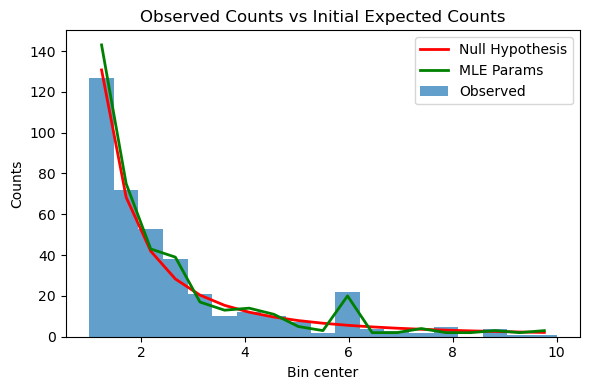

In [ ]:
# Plot the observed counts and the initial/optimized expected counts
plt.figure(figsize=(6, 4))
# plt.subplot(121)
plt.bar(bin_centers, observed_counts, alpha=0.7, label="Observed", width=np.diff(bin_edges))
plt.plot(bin_centers, power_law(bin_centers, a=a, index=index), label="Null Hypothesis", color='r', linewidth=2)
plt.plot(bin_centers, expected_counts_opt, label="MLE Params", color='g', linewidth=2)

plt.xlabel("Bin center")
plt.ylabel("Counts")
# plt.yscale("log")
plt.legend()
plt.title("Observed Counts vs Initial Expected Counts")


plt.tight_layout()
plt.show()


In [ ]:
# Calculate the likelihood ratio test statistic
lr_statistic = llr_test(bin_centers, observed_counts)

# Calculate the p-value using a chi-square distribution
p_value = chi2.sf(lr_statistic, df=2)  # Two degrees of freedom for the difference in number of parameters

# Print the results
print("Likelihood ratio test statistic:", lr_statistic)
print("p-value:", p_value)
if p_value < 0.05:
    print("The null hypothesis is rejected at the 95% significance level.")
else:
    print("The null hypothesis is not rejected at the 95% significance level.")

Likelihood ratio test statistic: 30.39002044699052
p-value: 2.517044579761756e-07
The null hypothesis is rejected at the 95% significance level.
